# mini-project Task 2: Gender classification





# Problem Formulation and data import:

The aim of this task is to build a classification model to classify gender labels from the raw audio files. 

In [1]:
#importing necessary modules to import the audio files into python
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, sys, re, pickle, glob
import urllib.request
import zipfile

import IPython.display as ipd
from tqdm import tqdm
import librosa

drive.mount('/content/drive')

Mounted at /content/drive


The path for the audio files are stored in the following variables. Since the audio files belong to 5 different folders, it consists of 5 path variables. 

In [2]:
path_1 = '/content/drive/MyDrive/Data/MLEndLS/sample/MLEndLS_1/*.wav'
path_2 =  '/content/drive/MyDrive/Data/MLEndLS/sample/MLEndLS_2/*.wav'
path_3 =  '/content/drive/MyDrive/Data/MLEndLS/sample/MLEndLS_3/*.wav'
path_4 = '/content/drive/MyDrive/Data/MLEndLS/sample/MLEndLS_4/*.wav'
path_5 =  '/content/drive/MyDrive/Data/MLEndLS/sample/MLEndLS_5/*.wav'

In [3]:
#importing the files from the path variables into a list using glob()
files_1 = glob.glob(path_1)
files_2 = glob.glob(path_2)
files_3 = glob.glob(path_3)
files_4 = glob.glob(path_4)
files_5 = glob.glob(path_5)

In [4]:
files_all = files_1 + files_2 + files_3 + files_4 + files_5
len(files_all),type(files_all)

(2498, list)

The glob module or the function glob.glob() in general assists in retrieving files from a directory recursively as shown above. The number of files are 2,498 and are saved in a list. 

In [5]:
#this loop helps us listen to the audio in the python kernel using ipd.Audio
for _ in range(3):
  n = np.random.randint(450)
  display(ipd.Audio(files_all[n]))


As the files are extracted onto a list of audio signals, we can go on to map the file id with the metadata available. 

The data at hand is a collection of recordings described by 5 attributes, namely: Area, Spot, in_out, participant. The 'in_out' column would be the potential label of the classification model since the premise of this task is to classify if the files have been recorded in a location that is indoors or outdoors. 

In [6]:
#importing the metadata into pandas dataframe
MLEndLS_df = pd.read_csv('/content/task2_gender.csv').set_index('file_id')
MLEndLS_df = MLEndLS_df.loc[:, ~MLEndLS_df.columns.str.contains('^Unnamed')]
MLEndLS_df

area       spot Participant  gender
file_id                                            
0001.wav     british     street        S151    male
0002.wav  kensington   dinosaur        S127    male
0003.wav      campus     square         S18    male
0004.wav  kensington     hintze        S179    male
0005.wav      campus     square        S176    male
...              ...        ...         ...     ...
2496.wav     westend  trafalgar        S151    male
2497.wav      campus     square          S6  female
2498.wav     westend   national         S96    male
2499.wav     british     room12         S73    male
2500.wav     british     room12         S58    male

[2498 rows x 4 columns]

In [7]:
#to check if the file ids match the format mentioned in the dataframe above
for file in files_all:
  print(file.split('/')[-1])

0026.wav
0047.wav
0042.wav
0007.wav
0009.wav
0059.wav
0020.wav
0002.wav
0031.wav
0045.wav
0055.wav
0027.wav
0041.wav
0010.wav
0037.wav
0032.wav
0023.wav
0028.wav
0022.wav
0062.wav
0054.wav
0005.wav
0015.wav
0006.wav
0025.wav
0058.wav
0048.wav
0051.wav
0019.wav
0014.wav
0061.wav
0040.wav
0018.wav
0063.wav
0044.wav
0016.wav
0004.wav
0024.wav
0017.wav
0057.wav
0029.wav
0021.wav
0008.wav
0039.wav
0053.wav
0052.wav
0036.wav
0001.wav
0060.wav
0043.wav
0050.wav
0049.wav
0030.wav
0038.wav
0013.wav
0046.wav
0003.wav
0034.wav
0035.wav
0011.wav
0012.wav
0056.wav
0201.wav
0119.wav
0079.wav
0265.wav
0140.wav
0074.wav
0224.wav
0225.wav
0129.wav
0110.wav
0263.wav
0084.wav
0242.wav
0168.wav
0237.wav
0148.wav
0123.wav
0124.wav
0239.wav
0155.wav
0125.wav
0126.wav
0236.wav
0128.wav
0261.wav
0072.wav
0202.wav
0152.wav
0251.wav
0069.wav
0212.wav
0213.wav
0199.wav
0106.wav
0222.wav
0175.wav
0240.wav
0160.wav
0101.wav
0132.wav
0247.wav
0177.wav
0167.wav
0120.wav
0245.wav
0186.wav
0102.wav
0082.wav
0150.wav
0

The iteration above displays a list of files within a range that consist of extentions just as those mentioned in the metadata dataframe. Consequently proving that we can extract the acoustic features from the list of audio files and use the metadata to build a supervised classification model.

# Transformation 

As we already know that audio files are complex, it is highly dimensional, "each audio frame is a data record that contains the samples for all of the channels available in an audio signal". As audio signals are recorded using digital devices it consists of a time-series upon the amplitude of the sound wave. A sample of an audio wave is described as that captured moment in a sound wave which can then be collectively viewed together as a series of samples representing the original audio signal. 

The librosa module assists in analysing and extracting the sound features of an audio signal. 

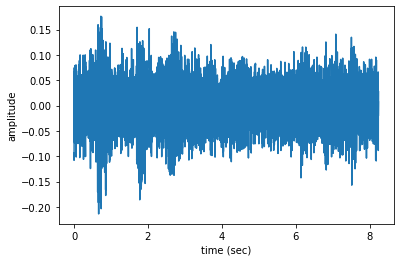

In [8]:
#to plot the audio signals 
n = 53
fs = None 
x, fs = librosa.load(files_all[n], sr = fs )
t = np.arange(len(x))/fs
plt.plot(t,x)
plt.xlabel('time (sec)')
plt.ylabel('amplitude')
plt.show()
display(ipd.Audio(files_all[n]))

In [9]:
MLEndLS_df.loc[files_all[53].split('/')[-1]]

area           southbank
spot                book
Participant         S126
gender              male
Name: 0038.wav, dtype: object

The audio signal extracted from files_all above shows an example of a collection of samples plotted collectively to display an original audio signal. The n = 53 used in the loop is then used to display the information of this audio signal from the dataframe. 

We can see that by using the audio from the index we are informed of the area, spot, participant and its gender feature. 

We can calculate the number of samples this audio has by using the very same librosa function, which subsequently uses the sample rate to extract the length of the original sample.

In [10]:
n=53
x, fs = librosa.load(files_all[n],sr=fs)
print('This audio signal has', len(x), 'samples')

This audio signal has 363384 samples


The number of samples are 363384. It is quite evident that these many number of samples exhibit high dimensionality, proving that the number of parameters must be higher than number of samples to train our model. 

Hence, we extract the features power, pitch_mean, pitch_standard deviation, and the fraction of the voiced region by a function.  

In [11]:
def getPitch(x,fs,winLen=0.02):
  #winLen = 0.02 
  p = winLen*fs
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//2
  f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,
                                                 frame_length=frame_length,hop_length=hop_length)
  return f0,voiced_flag

In [12]:
def getXy(files,labels_file, scale_audio=False, onlySingleDigit=False):
  X,y =[],[]
  for file in tqdm(files):
    fileID = file.split('/')[-1]
    file_name = file.split('/')[-1]
    yi = labels_file.loc[fileID]['gender']=='male'

    fs = None # if None, fs would be 22050
    x, fs = librosa.load(file,sr=fs)
    if scale_audio: x = x/np.max(np.abs(x))
    f0, voiced_flag = getPitch(x,fs,winLen=0.02)
      
    power = np.sum(x**2)/len(x)
    pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
    pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
    voiced_fr = np.mean(voiced_flag)
    

    xi = [power,pitch_mean,pitch_std,voiced_fr]
    X.append(xi)
    y.append(yi)

  return np.array(X),np.array(y)

In [ ]:
X,y = getXy(files_all, labels_file=MLEndLS_df, scale_audio=True, onlySingleDigit=True)

100%|██████████| 2498/2498 [1:10:21<00:00,  1.69s/it]


The features extracted from using the functions can be stored in a dataframe.

In [13]:
df = pd.read_csv('gender_xy.csv')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

X = np.column_stack([df.Power,df.Pitch_mean,df.Pitch_stdev,df.Fraction_region])
y = df.label

In [14]:
print('The shape of X is', X.shape) 
print('The shape of y is', y.shape)


The shape of X is (2498, 4)
The shape of y is (2498,)


In [15]:
print(' The number of male recordings is ', np.count_nonzero(y))
print(' The number of female recordings is ', y.size - np.count_nonzero(y))

 The number of male recordings is  1514
 The number of female recordings is  984


In [ ]:
#to view the design matrix for the features extracted
print(X[:5])

[[9.66975689e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.29284189e-02 1.27115114e+02 1.63744189e+01 9.15915916e-02]
 [5.34790698e-03 2.05667512e+02 9.53106524e+01 1.15841584e-01]
 [7.56088930e-03 1.21093099e+02 2.64785124e+01 8.78787879e-02]
 [7.26119064e-03 2.39874270e+02 4.74032835e+01 9.61038961e-02]]


# Machine Learning pipeline

This pipeline consists of splitting the dataset into 70%- training set and a 30% of test set. This is done so to first train the model using the right parameters. Furthermore, by using the training set a grid search cross validation is to be performed to tune the hyperparameters of a Random Forest Classifier. The best hyper parameters obtained are then specifically used to fit the training dataset onto the model and then predict the accuracy of the test set

By extracting the features into X and y arrays we can build a model for the classification. 

# Methodology 

The models used in this classification project is Random Forest classifier. Although KNN classifier has been tested at an earlier stage, since the features extracted are complex, Random Forest Classifier is used.  

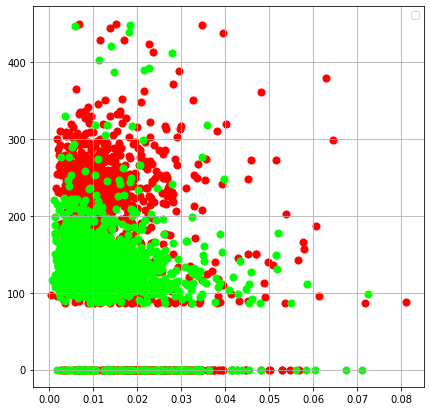

In [16]:
plt.figure(figsize=(7, 7))

scatter = plt.scatter(X[y==0,0], X[y==0,1], s=50 , color= '#FF0000' )
scatter = plt.scatter(X[y==1,0], X[y==1,1], s=50 , color= '#00FF00') 

plt.legend()
plt.grid(True)
plt.show()

The scatter plot distribution shows a majority of recordings done by one class over the other however, it is difficult to distinguish. It is evident that majority of the data points in the dataset overlap. However, we could create a model to predict the labels to check if the model caters to the data input. 

In [17]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

#splitting the dataset into train and test with a test size of 30% of the initial data
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state = 43)

The data split using train test split is done so where the training data of 70% will be used to train the model using cross validation while the remaining 30% would serve as our ultimate test set. 

Minimum error:- 0.15733333333333333 at K = 16


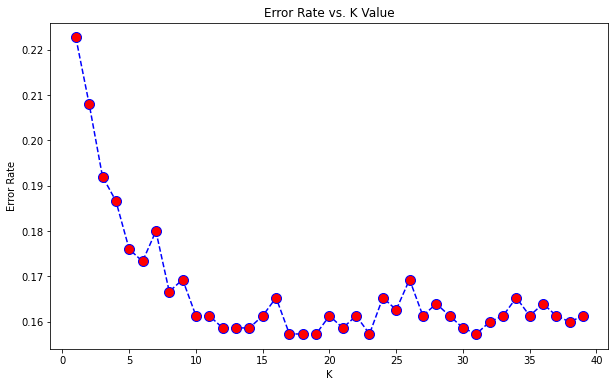

In [18]:
error_rate = []
for i in range(1,40):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train,y_train)
    y_predi = knn.predict(X_test)
    error_rate.append(np.mean(y_predi != y_test))

plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
print("Minimum error:-",min(error_rate),"at K =",error_rate.index(min(error_rate)))


The minimum error rate is shown to be of 15.73% while using a knn model with a neighbours = 16. Although the error rate is at its minimum, a model with such an error may not render the right results we require with n_neighbours of 16. It may render the chances of overfitting the data as we increase the 'k' value.

# Modelling

Ensembles are methods that combine multiple models to create powerful ones. Random Forests are one of those models that address and rectify the drawbacks we may face while using models like Decision Trees. 

It consists of the n_estimator parameter that decides on the number of decision trees required, the max_depth parameter and minimum sample split. These parameters assist in determining the right model for the data input. 

As a first step before we create a model is to scale the data, just so the model predicts the features in an equal footing. 


In [19]:
#function to scale the data 
def scale_data(data):
    '''function to scale the features using min-max normalisaton 
    into a range of 1 to 10 '''
    data = (((data - data.min())/(data.max() - data.min())) * 9)+ 1
    return data


In [20]:
#using the training and testing data set used above 
X_train_df = pd.DataFrame(X_train, columns = ['Power','Pitch_mean','Pitch_stdev','Fraction_region'])
X_test_df = pd.DataFrame(X_test, columns = ['Power','Pitch_mean','Pitch_stdev','Fraction_region'])

#scale the data
X_train_df = scale_data(X_train_df)
X_test_df = scale_data(X_test_df)

#convert it back to a design matrix
X_train = np.column_stack([X_train_df.Power, X_train_df.Pitch_mean, X_train_df.Pitch_stdev,
                          X_train_df.Fraction_region])
X_test = np.column_stack([X_test_df.Power, X_test_df.Pitch_mean, X_test_df.Pitch_stdev,
                          X_test_df.Fraction_region])

In [21]:
#instantiate the random forest classifier 
forest = RandomForestClassifier()

We can implement a simple grid search cross validation for the model to perform its validation over a list of parameters. This step can be viewed as a hyperparameter tuning step to select the right parameter for the model. 

It assists in choosing the right hyperparameter that possibly would not cause the problems of overfitting or underfitting the validation dataset.

In [22]:
from sklearn.model_selection import GridSearchCV

#list of hyperparameters to loop through 
n_estimators = [3, 10, 20, 50, 100]
max_depth = range(1,15,3)
min_samples_split = [2, 5, 10, 15, 50]

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split)

gridF = GridSearchCV(forest, hyperF, cv = 3, verbose = 1, 
                      n_jobs = -1)
#fitting the best parameter to obtain the accuracy over test
#and training dataset
bestF = gridF.fit(X_train, y_train)

print("Best training score : ",bestF.score(X_train,y_train))


Fitting 3 folds for each of 125 candidates, totalling 375 fits
Best training score :  0.8729977116704806


In [23]:
print("The best hyperparameters to train the model with are: {} ".format(gridF.best_params_))

The best hyperparameters to train the model with are: {'max_depth': 4, 'min_samples_split': 2, 'n_estimators': 20} 


In [24]:
grid_search_results = pd.DataFrame(gridF.cv_results_)
display(grid_search_results)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0         0.007633      0.000663         0.001468        0.000116   
1         0.018322      0.000782         0.002263        0.000217   
2         0.033886      0.000714         0.003591        0.000050   
3         0.083469      0.000689         0.009105        0.001814   
4         0.171782      0.002938         0.014824        0.000060   
..             ...           ...              ...             ...   
120       0.008488      0.000589         0.001086        0.000037   
121       0.025182      0.001385         0.002158        0.000023   
122       0.049875      0.000618         0.003798        0.000072   
123       0.121927      0.001729         0.010797        0.003452   
124       0.234555      0.016511         0.014831        0.002229   

    param_max_depth param_min_samples_split param_n_estimators  \
0                 1                       2                  3   
1                 1                       2                 10   
2                 1                       2                 20   
3                 1                       2                 50   
4                 1                       2                100   
..              ...                     ...                ...   
120              13                      50                  3   
121              13                      50                 10   
122              13                      50                 20   
123              13                      50                 50   
124              13                      50                100   

                                                params  split0_test_score  \
0    {'max_depth': 1, 'min_samples_split': 2, 'n_es...           0.723842   
1    {'max_depth': 1, 'min_samples_split': 2, 'n_es...           0.794168   
2    {'max_depth': 1, 'min_samples_split': 2, 'n_es...           0.811321   
3    {'max_depth': 1, 'min_samples_split': 2, 'n_es...           0.819897   
4    {'max_depth': 1, 'min_samples_split': 2, 'n_es...           0.819897   
..                                                 ...                ...   
120  {'max_depth': 13, 'min_samples_split': 50, 'n_...           0.823328   
121  {'max_depth': 13, 'min_samples_split': 50, 'n_...           0.840480   
122  {'max_depth': 13, 'min_samples_split': 50, 'n_...           0.831904   
123  {'max_depth': 13, 'min_samples_split': 50, 'n_...           0.838765   
124  {'max_depth': 13, 'min_samples_split': 50, 'n_...           0.838765   

     split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0             0.686106           0.823024         0.744324        0.057742   
1             0.789022           0.831615         0.804935        0.018982   
2             0.789022           0.745704         0.782016        0.027242   
3             0.792453           0.831615         0.814655        0.016412   
4             0.794168           0.831615         0.815227        0.015640   
..                 ...                ...              ...             ...   
120           0.828473           0.865979         0.839260        0.019010   
121           0.819897           0.879725         0.846701        0.024818   
122           0.831904           0.862543         0.842117        0.014443   
123           0.833619           0.876289         0.849558        0.019018   
124           0.828473           0.869416         0.845551        0.017390   

     rank_test_score  
0                125  
1                119  
2                124  
3                105  
4                102  
..               ...  
120               67  
121               11  
122               48  
123                3  
124               18  

[125 rows x 14 columns]

# Testing 



From the grid search cross validation applied to the model, we have obtained a training accuracy of 93.02%. However, using the best parameters mentioned can be used to check the test accuracy. 

This is done to train the model **only** with the best parameters.

As we had already split the dataset into 70% training and 30% test, the grid search cross validation had performed its analysis on the training dataset only. It split the dataset into 3 and treated. 

Hence, the remaining 30% of the original dataset is used to test the model using the best parameters.

In [25]:
forest_F= RandomForestClassifier(n_estimators=20,max_depth = 4,
                               min_samples_split= 2,random_state=2)
forest_fit= forest_F.fit(X_train,y_train)
print("The test accuracy obtained for the model built is: {}".format(forest_fit.score(X_test,y_test)))

The test accuracy obtained for the model built is: 0.84


In [26]:
from sklearn.metrics import confusion_matrix
y_pred = forest_F.predict(X_test)

confusion2 = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n{}".format(confusion2))


Confusion matrix:
[[247  50]
 [ 70 383]]


## Conclusion

The test accuracy obtained is of 84% after hyperparamter tuning the classifier. This result however, supports the minimum error rate of 15.73% obtained using K-nearest neighbour classification. Had we used KNN, the possibility of obtaining a better accuracy may not have been the case. 

The confusion matrix displays the true negative. false negative, true positive and false positive predictions by the model. It inclines towards classifying the data as male gendered and one possible reason could be that this class is higher in number in comparison to the female class. Although, we cannot rule out the issue by stating the data is imbalanced. The model renders an accuracy of 84% which is significantly higher than the classifier that renders an accuracy of 56% for indoors and outdoors. This only helps us realise the abnormalities of the features extracted. 

Classifying a dataset into a male or female classification seems to have a better result due to various reasons. One of those being its dependence on features like pitch. 

It follows the underlying rule of catering to the dataset. The features extracted from the audio signals are only 4, consequently, this could lead to the possibility of diving deep and extracting further features from the signals like MFCC, paving way for a further study in this area.  

